In [10]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# A Spark Session is how we interact with Spark SQL to create Dataframes
from pyspark.sql import SparkSession

# PySpark function for replacing characters using a regex. We'll use this to remove newline characters.
from pyspark.sql.functions import regexp_replace, col

from pyspark.sql.types import StructField, StructType, StringType, IntegerType, TimestampType

# This will help catch some PySpark errors
from py4j.protocol import Py4JJavaError

# Create a SparkSession under the name "reddit". Viewable via the Spark UI
spark = SparkSession.builder.appName("twitter-sentiment").getOrCreate()


In [15]:
TRAIN_DATA_PATH = "/home/haitien/Desktop/TwitterSentimentAnalysis_BigData20191/data/training.1600000.processed.noemoticon.csv"
TEST_DATA_PATH = "/home/haitien/Desktop/TwitterSentimentAnalysis_BigData20191/data/testdata.manual.2009.06.14.csv"

In [12]:
fields = [StructField("label", IntegerType(), True),
          StructField("tweet_id", StringType(), True),
          StructField("date", TimestampType(), True),
          StructField("query_string", StringType(), True),
          StructField("user", StringType(), True),
          StructField("text", StringType(), True)]
schema = StructType(fields)


In [20]:
df_train = spark.read.format("csv").schema(schema).option("header", "false").load(TRAIN_DATA_PATH)
df_test = spark.read.format("csv").schema(schema).option("header", "false").load(TEST_DATA_PATH)

In [30]:
df_train.printSchema()

root
 |-- label: integer (nullable = true)
 |-- tweet_id: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- query_string: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



In [22]:
df_train.select(['text', 'label']).show()

+--------------------+-----+
|                text|label|
+--------------------+-----+
|@switchfoot http:...|    0|
|is upset that he ...|    0|
|@Kenichan I dived...|    0|
|my whole body fee...|    0|
|@nationwideclass ...|    0|
|@Kwesidei not the...|    0|
|         Need a hug |    0|
|@LOLTrish hey  lo...|    0|
|@Tatiana_K nope t...|    0|
|@twittera que me ...|    0|
|spring break in p...|    0|
|I just re-pierced...|    0|
|@caregiving I cou...|    0|
|@octolinz16 It it...|    0|
|@smarrison i woul...|    0|
|@iamjazzyfizzle I...|    0|
|Hollis' death sce...|    0|
|about to file taxes |    0|
|@LettyA ahh ive a...|    0|
|@FakerPattyPattz ...|    0|
+--------------------+-----+
only showing top 20 rows



In [21]:
df_test.select(['text', 'label']).show()

+--------------------+-----+
|                text|label|
+--------------------+-----+
|@stellargirl I lo...|    4|
|Reading my kindle...|    4|
|Ok, first assesme...|    4|
|@kenburbary You'l...|    4|
|@mikefish  Fair e...|    4|
|@richardebaker no...|    4|
|Fuck this economy...|    0|
|Jquery is my new ...|    4|
|       Loves twitter|    4|
|how can you not l...|    4|
|Check this video ...|    2|
|@Karoli I firmly ...|    0|
|House Corresponde...|    4|
|Watchin Espn..Jus...|    4|
|dear nike, stop w...|    0|
|#lebron best athl...|    4|
|I was talking to ...|    0|
|i love lebron. ht...|    4|
|@ludajuice Lebron...|    0|
|@Pmillzz lebron I...|    4|
+--------------------+-----+
only showing top 20 rows



In [25]:
print("Number rows on train data = {}".format(df_train.count()))
print("Number rows on test data = {}".format(df_test.count()))

Number rows on train data = 1600000
Number rows on test data = 498


In [28]:
df_train.groupBy('label').count().show()

+-----+------+
|label| count|
+-----+------+
|    4|800000|
|    0|800000|
+-----+------+



In [29]:
df_test.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    4|  182|
|    2|  139|
|    0|  177|
+-----+-----+



In [48]:
df_train.select('text').show()

+--------------------+
|                text|
+--------------------+
|@switchfoot http:...|
|is upset that he ...|
|@Kenichan I dived...|
|my whole body fee...|
|@nationwideclass ...|
|@Kwesidei not the...|
|         Need a hug |
|@LOLTrish hey  lo...|
|@Tatiana_K nope t...|
|@twittera que me ...|
|spring break in p...|
|I just re-pierced...|
|@caregiving I cou...|
|@octolinz16 It it...|
|@smarrison i woul...|
|@iamjazzyfizzle I...|
|Hollis' death sce...|
|about to file taxes |
|@LettyA ahh ive a...|
|@FakerPattyPattz ...|
+--------------------+
only showing top 20 rows



In [59]:
from pyspark.sql.functions import trim, lower
# Emails
emailsRegex=r'[\w\.-]+@[\w\.-]+'

# Mentions
userMentionsRegex=r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9]+)'

#Urls
urlsRegex=r'(f|ht)(tp)(s?)(://)(.*)[.|/][^ ]+'

#Numerics
numsRegex=r"\b\d+\b"

punctuationNotEmoticonsRegex=r'(?<=\w)[^\s\w](?![^\s\w])'


def clean_tweet(col):
    col = lower(col)
    col = regexp_replace(col, "n't", " not")
    col = regexp_replace(col, emailsRegex, " ")
    col = regexp_replace(col, userMentionsRegex, " ")
    col = regexp_replace(col, urlsRegex, " ")
    col = regexp_replace(col, numsRegex, " ")
    col = regexp_replace(col, punctuationNotEmoticonsRegex, " ")
    col = regexp_replace(col, r'(.)\1{2,}', r'\1\1')
    col = trim(col)
    return col

df_train_cleaned = df_train.select(['label', clean_tweet(col("text")).alias("text")])

In [62]:
df_train_cleaned.where(df_train_cleaned.text.isNull()).count()

0

In [64]:
df_train_cleaned.coalesce(1).write.format("csv").save("/home/haitien/Desktop/TwitterSentimentAnalysis_BigData20191/data/train_cleaned.csv")

In [83]:
df_train = spark.read.csv("/home/haitien/Desktop/TwitterSentimentAnalysis_BigData20191/data/train_cleaned.csv")

In [85]:
df_train.limit(10).toPandas()

,_c0,_c1
0,0,11- a11 that s a bummer11you shoulda got davi...
1,0,is upset that he ca not update his facebook by...
2,0,i dived many times for the ball managed to sa...
3,0,my whole body feels itchy and like its on fire
4,0,no it s not behaving at all i m mad why am ...
5,0,not the whole crew
6,0,need a hug
7,0,"hey long time no see yes.. rains a bit ,only..."
8,0,_k nope they did not have it
9,0,que me muera ?


In [86]:
df_train = df_train.withColumnRenamed("_c0", "label")
df_train = df_train.withColumnRenamed("_c1", "text")

In [ ]:
df_train.show()

In [ ]:
from pyspark.sql.functions import rand, when
df_train = df_train.orderBy(rand()) \
                   .limit(100000) \
                   .withColumn("label", when(col("label") > 0, 1).otherwise(1)) \
                   .select(["label", "text"])

In [ ]:
df_train.where(df_train.text.isNull()).count()

In [ ]:
df_train = df_train.na.drop(subset=["text"])

In [ ]:
(train_set, val_set) = df_train.randomSplit([0.8, 0.2], seed = 2000)

In [ ]:
train_set.show()

In [ ]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression

#  class_k probability: 1/(1 + exp(-rawPrediction_k))


tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.001)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])


pipelineFit = pipeline.fit(train_set)
train_df = pipelineFit.transform(train_set)
val_df = pipelineFit.transform(val_set)
train_df.show(5)

In [ ]:
df_test = df_test.filter(col("label") != 2.0) \
                 .withColumn("label", when(col("label") > 0, 1.0).otherwise(0.0)) \
                 .select(["label", "text"])

In [ ]:
predictions = pipelineFit.transform(df_test)
predictions.limit(10).toPandas()

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)

In [ ]:
pipelineFit.write().save("saved_model/model2")

In [ ]:
from pyspark.ml import PipelineModel
model1 = PipelineModel.read().load("saved_model/model")
model2 = PipelineModel.read().load("saved_model/model2")

In [ ]:
predictions = model1.transform(df_test)

In [ ]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)

In [ ]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import matplotlib.pyplot as plt
%matplotlib inline

# Utility class for plotting ROC curve (https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve)
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

preds = predictions.select("label", "probability") \
                   .rdd.map(lambda row: (float(row["probability"][1]), float(row["label"])))
roc_points = CurveMetrics(preds).get_curve("roc")

# Plot ROC curve
fig = plt.figure()
x_val = [x[0] for x in roc_points]
y_val = [x[1] for x in roc_points]
plt.title("ROC curve on test set")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot(x_val, y_val)
plt.show()

+-----+--------------------+
|label|                text|
+-----+--------------------+
|    0|11- a11  that s a...|
|    0|is upset that he ...|
|    0|i dived many time...|
|    0|my whole body fee...|
|    0|no  it s not beha...|
|    0|  not the whole crew|
|    0|          need a hug|
|    0|hey  long time no...|
|    0|_k nope they did ...|
|    0|      que me muera ?|
|    0|spring break in p...|
|    0|i just re pierced...|
|    0|i could not bear ...|
|    0|it it counts  idk...|
|    0|i would ve been t...|
|    0|i wish i got to w...|
|    0|hollis  death sce...|
|    0| about to file taxes|
|    0|ahh ive always wa...|
|    0|oh dear  were you...|
+-----+--------------------+
only showing top 20 rows



In [91]:
from pyspark.sql.functions import rand, when
df_train = df_train.orderBy(rand()) \
                   .limit(100000) \
                   .withColumn("label", when(col("label") > 0, 1).otherwise(1)) \
                   .select(["label", "text"])

In [97]:
df_train.where(df_train.text.isNull()).count()

217

In [98]:
df_train = df_train.na.drop(subset=["text"])

In [99]:
(train_set, val_set) = df_train.randomSplit([0.8, 0.2], seed = 2000)

In [100]:
train_set.show()

+-----+--------------------+
|label|                text|
+-----+--------------------+
|    1|!  pairs of conve...|
|    1|!  unfortunately ...|
|    1|!  yoopers spell ...|
|    1|! do not know how...|
|    1|               ! hey|
|    1|! i love it  than...|
|    1|! i was just in m...|
|    1|!! hello  i wo no...|
|    1|!! you rock demi!...|
|    1|!11twitter  how t...|
|    1|   !?  what happened|
|    1|!identica group &...|
|    1|#  iphone has wif...|
|    1|#  is not fair.. ...|
|    1|#  jimmy johnson ...|
|    1|#  still st regis...|
|    1|#100pushups wk2 d...|
|    1|#10yearsofenema ....|
|    1|#3hotwords pull m...|
|    1|#3hotwords that i...|
+-----+--------------------+
only showing top 20 rows



In [101]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression

#  class_k probability: 1/(1 + exp(-rawPrediction_k))


tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.001)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])


pipelineFit = pipeline.fit(train_set)
train_df = pipelineFit.transform(train_set)
val_df = pipelineFit.transform(val_set)
train_df.show(5)

+-----+--------------------+--------------------+--------------------+--------------------+-----------+----------+
|label|                text|               words|            features|       rawPrediction|probability|prediction|
+-----+--------------------+--------------------+--------------------+--------------------+-----------+----------+
|    1|!  pairs of conve...|[!, , pairs, of, ...|(262144,[7401,963...|[-Infinity,Infinity]|  [0.0,1.0]|       1.0|
|    1|!  unfortunately ...|[!, , unfortunate...|(262144,[28990,58...|[-Infinity,Infinity]|  [0.0,1.0]|       1.0|
|    1|!  yoopers spell ...|[!, , yoopers, sp...|(262144,[27526,28...|[-Infinity,Infinity]|  [0.0,1.0]|       1.0|
|    1|! do not know how...|[!, do, not, know...|(262144,[24417,28...|[-Infinity,Infinity]|  [0.0,1.0]|       1.0|
|    1|               ! hey|            [!, hey]|(262144,[28990,66...|[-Infinity,Infinity]|  [0.0,1.0]|       1.0|
+-----+--------------------+--------------------+--------------------+----------

In [102]:
df_test = df_test.filter(col("label") != 2.0) \
                 .withColumn("label", when(col("label") > 0, 1.0).otherwise(0.0)) \
                 .select(["label", "text"])

In [103]:
predictions = pipelineFit.transform(df_test)
predictions.limit(10).toPandas()

,label,text,words,features,rawPrediction,probability,prediction
0,1.0,@stellargirl I loooooooovvvvvveee my Kindle2. ...,"[@stellargirl, i, loooooooovvvvvveee, my, kind...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-inf, inf]","[0.0, 1.0]",1.0
1,1.0,Reading my kindle2... Love it... Lee childs i...,"[reading, my, kindle2..., , love, it..., lee, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-inf, inf]","[0.0, 1.0]",1.0
2,1.0,"Ok, first assesment of the #kindle2 ...it fuck...","[ok,, first, assesment, of, the, #kindle2, ......","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-inf, inf]","[0.0, 1.0]",1.0
3,1.0,@kenburbary You'll love your Kindle2. I've had...,"[@kenburbary, you'll, love, your, kindle2., i'...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-inf, inf]","[0.0, 1.0]",1.0
4,1.0,@mikefish Fair enough. But i have the Kindle2...,"[@mikefish, , fair, enough., but, i, have, the...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-inf, inf]","[0.0, 1.0]",1.0
5,1.0,@richardebaker no. it is too big. I'm quite ha...,"[@richardebaker, no., it, is, too, big., i'm, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-inf, inf]","[0.0, 1.0]",1.0
6,0.0,Fuck this economy. I hate aig and their non lo...,"[fuck, this, economy., i, hate, aig, and, thei...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-inf, inf]","[0.0, 1.0]",1.0
7,1.0,Jquery is my new best friend.,"[jquery, is, my, new, best, friend.]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-inf, inf]","[0.0, 1.0]",1.0
8,1.0,Loves twitter,"[loves, twitter]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-inf, inf]","[0.0, 1.0]",1.0
9,1.0,how can you not love Obama? he makes jokes abo...,"[how, can, you, not, love, obama?, he, makes, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-inf, inf]","[0.0, 1.0]",1.0


In [104]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)

0.5

In [108]:
pipelineFit.write().save("saved_model/model2")

In [109]:
from pyspark.ml import PipelineModel
model1 = PipelineModel.read().load("saved_model/model")
model2 = PipelineModel.read().load("saved_model/model2")

In [110]:
predictions = model1.transform(df_test)

In [111]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)

0.6508350406655491

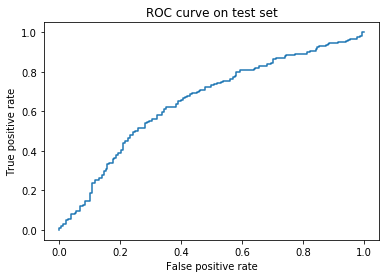

In [112]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import matplotlib.pyplot as plt
%matplotlib inline

# Utility class for plotting ROC curve (https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve)
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

preds = predictions.select("label", "probability") \
                   .rdd.map(lambda row: (float(row["probability"][1]), float(row["label"])))
roc_points = CurveMetrics(preds).get_curve("roc")

# Plot ROC curve
fig = plt.figure()
x_val = [x[0] for x in roc_points]
y_val = [x[1] for x in roc_points]
plt.title("ROC curve on test set")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot(x_val, y_val)
plt.show()